In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.definitions import _compute
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [3]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler.from_specs("ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [4]:
da_tp = open_da(
    "ERA5", "surf", "tp", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [5]:
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [6]:
da_sst = open_da(
    "ERA5", "surf", "sst", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [7]:
da_mslp = open_da(
    "ERA5", "surf", "sst", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)

In [106]:
def get_persistent_spell_times_from_som(props_as_df, labels, minlen: int = 4, nt_before: int = 0, nt_after: int = 0):
    labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
    labels_df = labels_df.cast({"time": props_as_df["time"].dtype})
    props_as_df = props_as_df.filter(pl.col("time").is_in(labels_df["time"]))
    index_columns = get_index_columns(props_as_df)
    index = props_as_df[index_columns].unique(maintain_order=True)

    out = labels_df["labels"].rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    out = out.with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.filter(pl.col("range") < len(index), pl.col("range") >= 0)
    out = out.with_columns(index[out["range"]])
    out = out.filter(pl.col("len") >= minlen)
    out = out.with_columns(pl.col("persistent_spell").rle_id())
    return out

In [107]:
spells = get_persistent_spell_times_from_som(props_as_df, labels, 40, nt_before=8)

In [150]:
spells = spells.with_columns(spells.group_by("persistent_spell").agg(dt=pl.col("time").diff().fill_null(pl.duration(hours=6))).explode("dt"))

In [154]:
spells.filter(pl.col("dt") <= pl.duration(hours=6))

persistent_spell,len,value,start,range,relative_index,time,dt
u32,u32,i64,i64,i64,i64,datetime[ms],duration[ms]
0,43,15,0,0,0,1959-06-01 00:00:00,6h
0,43,15,0,1,1,1959-06-01 06:00:00,6h
0,43,15,0,2,2,1959-06-01 12:00:00,6h
0,43,15,0,3,3,1959-06-01 18:00:00,6h
0,43,15,0,4,4,1959-06-02 00:00:00,6h
…,…,…,…,…,…,…,…
41,81,15,22080,22156,76,2019-06-20 00:00:00,6h
41,81,15,22080,22157,77,2019-06-20 06:00:00,6h
41,81,15,22080,22158,78,2019-06-20 12:00:00,6h


In [108]:
from typing import Tuple
def spells_df_to_standard_spells(spells: pl.DataFrame) -> Tuple[list, np.ndarray]:
    num_spells = spells["persistent_spell"].max() + 1

    spells_ts = []
    spells_as_np = np.zeros((num_spells, 2), dtype="datetime64[ns]")
    for i, df_ in spells.group_by("persistent_spell", maintain_order=True):
        i = i[0]
        spells_ts.append(df_["time"].to_numpy().astype("datetime64[ns]"))
        spells_as_np[i, 0] = df_.filter(pl.col("relative_index") == 0)["time"].item()
        spells_as_np[i, 1] = df_[-1, "time"]
    return spells_ts, spells_as_np

In [134]:
import pandas as pd
spells_ts, spells_as_np = spells_df_to_standard_spells(spells)
for i in range(2):
    spells_as_np[:, i] = pd.Series(spells_as_np[:, i]).dt.round("1d").values
for i, spell_ in enumerate(spells_ts):
    spells_ts[i] = np.unique(pd.Series(spell_).dt.round("1d").values)

In [140]:
spells_ts[1]

array(['1959-08-30T00:00:00.000000000', '1959-08-31T00:00:00.000000000',
       '1959-09-01T00:00:00.000000000', '1960-06-01T00:00:00.000000000',
       '1960-06-02T00:00:00.000000000', '1960-06-03T00:00:00.000000000',
       '1960-06-04T00:00:00.000000000', '1960-06-05T00:00:00.000000000',
       '1960-06-06T00:00:00.000000000', '1960-06-07T00:00:00.000000000',
       '1960-06-08T00:00:00.000000000', '1960-06-09T00:00:00.000000000',
       '1960-06-10T00:00:00.000000000', '1960-06-11T00:00:00.000000000',
       '1960-06-12T00:00:00.000000000', '1960-06-13T00:00:00.000000000',
       '1960-06-14T00:00:00.000000000', '1960-06-15T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [142]:
spells_as_np[1, :]

array(['1960-06-01T00:00:00.000000000', '1960-06-15T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [135]:
tp_masked = mask_from_spells(da_tp, spells_ts, spells_as_np, time_before=np.timedelta64(2, "D"))

KeyError: "not all values found in index 'time_around_beg'"

In [124]:
tp_masked

<xarray.DataArray 'tp' (spell: 42, time_around_beg: 1, lat: 181, lon: 720)> Size: 22MB
dask.array<broadcast_to, shape=(42, 1, 181, 720), dtype=float32, chunksize=(42, 1, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * spell            (spell) int64 336B 0 1 2 3 4 5 6 7 ... 35 36 37 38 39 40 41
  * time_around_beg  (time_around_beg) timedelta64[ns] 8B 00:00:00
  * lat              (lat) float32 724B 0.0 0.5 1.0 1.5 ... 88.5 89.0 89.5 90.0
  * lon              (lon) float32 3kB -180.0 -179.5 -179.0 ... 179.0 179.5
    lengths          (spell) timedelta64[ns] 336B 11 days 14 days ... 20 days
    avg_val          (spell, time_around_beg) float64 336B nan nan ... nan nan
    absolute_time    (spell, time_around_beg) datetime64[ns] 336B NaT ... NaT

(<matplotlib.cm.ScalarMappable at 0x7f1d841fb190>,
 {'transform': <Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0.0 +to ...>
  Name: unknown
  Axis Info [cartesian]:
  - E[east]: Easting (unknown)
  - N[north]: Northing (unknown)
  - h[up]: Ellipsoidal height (metre)
  Area of Use:
  - undefined
  Coordinate Operation:
  - name: unknown
  - method: Equidistant Cylindrical
  Datum: Unknown based on WGS 84 ellipsoid
  - Ellipsoid: WGS 84
  - Prime Meridian: Greenwich,
  'levels': array([-0.0004, -0.0002,  0.0002,  0.0004]),
  'cmap': <colormaps.colormap.Colormap at 0x7f1db13efc10>,
  'norm': <matplotlib.colors.BoundaryNorm at 0x7f1cd753a510>,
  'extend': 'both'})

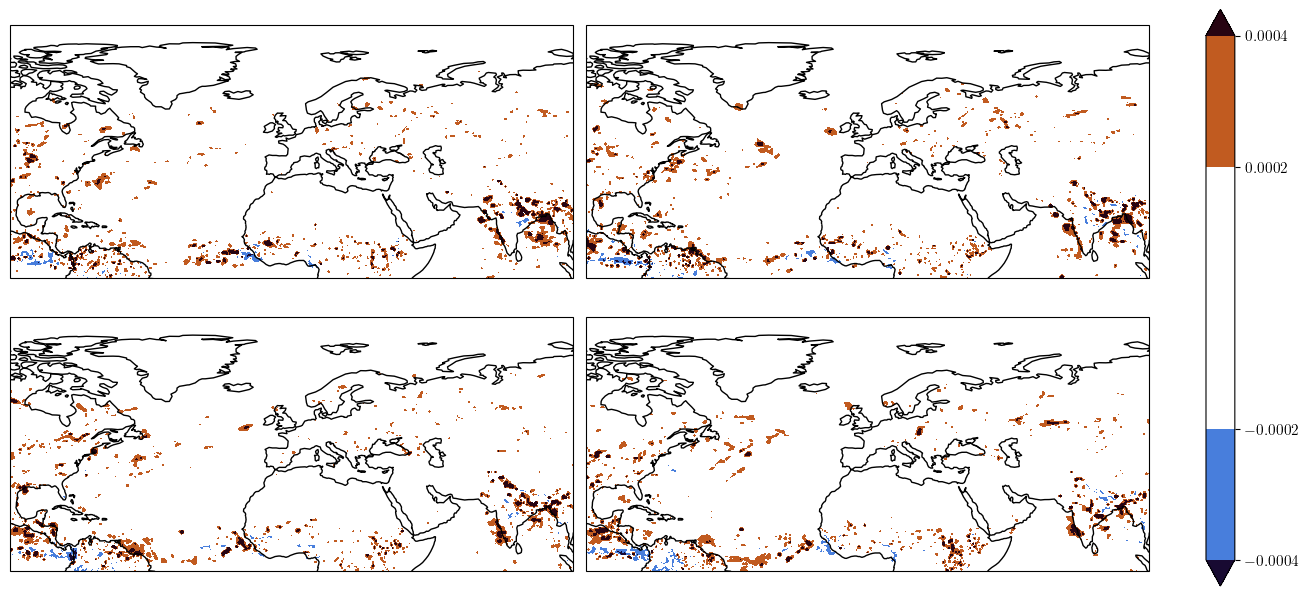

In [121]:
clu = Clusterplot(2, 2, get_region(da_tp))
_ = clu.add_contourf(tp_masked.mean("spell")[[0, 4, 8, 12]])

In [ ]:
clu = Clusterplot(1, 1, get_region(da_pvs_spells))
_ = clu.add_contourf([da_pvs_spells.sel(type="anti").mean("time")], cmap=colormaps.balance, levels=9)

In [ ]:
clu = Clusterplot(1, 1, get_region(da_pvs_spells))
_ = clu.add_contourf([da_pvs_spells.sel(type="cycl").mean("time")], cmap=colormaps.balance, levels=9)

In [ ]:
clu = Clusterplot(1, 1, get_region(da_T_spells))
_ = clu.add_contourf([da_T_spells.mean("time")], cmap=colormaps.BlWhRe, levels=9)

In [ ]:
clu = Clusterplot(1, 1, get_region(da_tp_spells))
_ = clu.add_contourf([da_tp_spells.mean("time")], cmap=colormaps.BlWhRe, levels=9)

In [9]:
def get_persistent_spell_times(props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None):
    props_as_df = extract_season_from_df(props_as_df, season)
    times = props_as_df["time"].unique()
    onejet = props_as_df.filter(pl.col("jet") == jet)
    out = onejet[metric]
    if metric == "com_speed":
        out = (out < out.quantile(0.2))
    else:
        out = (out > out.quantile(0.8))
    out = out.rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("value"), pl.col("len") >= 4).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.with_columns(time=times[out["range"]])
    return out

In [11]:
spells = get_persistent_spell_times(props_as_df, "com_speed", "EDJ", "JJA")

In [ ]:
spells

In [ ]:
spells.group_by("persistent_spell").first()["len"].top_k(10)

In [6]:
def get_persistent_jet_spells(props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None):
    props_as_df = extract_season_from_df(props_as_df, season)
    times = props_as_df["time"].unique()
    onejet = props_as_df.filter(pl.col("jet") == jet)
    out = onejet[metric] 
    if metric == "com_speed":
        out = (out < out.quantile(0.2))
    else:
        out = (out > out.quantile(0.8))
    out = out.rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("value"), pl.col("len") >= 4).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.with_columns(time=times[out["range"]])
    out = out.join(props_as_df, on="time").drop("value", "start", "range")
    return out

In [4]:
persistent_spells = get_persistent_jet_spells(props_as_df, "persistence", "EDJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [5]:
persistent_spells = get_persistent_jet_spells(props_as_df, "com_speed", "EDJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [6]:
persistent_spells = get_persistent_jet_spells(props_as_df, "persistence", "STJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [7]:
persistent_spells = get_persistent_jet_spells(props_as_df, "com_speed", "STJ", "JJA")
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])

In [9]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler.from_specs("ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    train_kwargs=dict(num_epochs=20),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [10]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "int", "com_speed", "persistence", "waviness1", "wavinessR16"]
times = props_as_df["time"].unique()
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
labels_df = pl.from_pandas(labels.to_dataframe().reset_index())
labels_time = labels_df["time"].unique(maintain_order=True)
persistent_spells = labels_df["labels"].rle().struct.unnest()
persistent_spells = persistent_spells.filter(pl.col("len") >= 8)
persistent_spells = persistent_spells.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
nt_before, nt_after = 8, 0
persistent_spells = persistent_spells.filter(pl.col("len") >= 4).with_columns(
    range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
    relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
)
persistent_spells = persistent_spells.with_row_index("persistent_spell").explode(["range", "relative_index"])
persistent_spells = persistent_spells.with_columns(time=times[persistent_spells["range"]])
persistent_spells = persistent_spells.join(props_as_df, on="time").drop("start", "range")

In [16]:
mean_ps = persistent_spells.group_by(["value", "relative_index", "jet"]).agg(**aggs).sort(["value", "relative_index", "jet"])
props_on_som = labels_df.join(props_as_df.cast({"time": labels_df["time"].dtype}), on="time")
props_on_som = props_on_som.drop("time").group_by(["labels", "jet"], maintain_order=True).mean().sort(["labels", "jet"])

In [17]:
x = mean_ps["relative_index"].unique()
data_var = "mean_s"
many_colors = colormaps.cet_g_bw(np.linspace(0, 1, 256))
fig, axes = honeycomb_panel(4, 6, ratio = 0.5)
axes = axes.ravel()
for value in range(24):
    ax = axes[value]
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("value") == value, pl.col("jet") == jet)
        x_ = x[:len(to_plot)]
        ax.plot(x_, to_plot[data_var], color=COLORS[2 - j])
        this_mean = props_on_som.filter(pl.col("labels") == value, pl.col("jet") == jet)
        if len(x_) == 0:
            continue
        ax.plot([x_[0], x_[-1]], [this_mean[data_var], this_mean[data_var]], ls="dashed", color=COLORS[2 - j])
    title = value + 1
    try:
        title = f"{title}, {to_plot['alive'][0]}"
    except IndexError:
        pass
    ax.set_title(title)

In [18]:
mean_ps = persistent_spells.group_by(["relative_index", "jet"]).agg(**aggs).sort(["relative_index", "jet"])

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])